In [3]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
from typing import Mapping

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [2]:
class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()


class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()


class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

In [3]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup
from bbtoolkit.structures.tensorgroups import DirectedTensor, DirectedTensorGroup


n_hd_neurons = 100

activity = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring1',
        weights=connectivity.hd.to.hd
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring2',
        weights=connectivity.hd.to.hd
    )
)


connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring1',
        weights=dict(phi=5)
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring2',
        weights=dict(phi=-3)
    )
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

In [4]:
connectivity.hd.to.hd

{'phi': 15, 'inhibitory_phi': 0.4, 'tau': 0.02, 'beta': 0.1, 'alpha': 5}

In [17]:
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.structures import DotDict
from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d
from bbtoolkit.utils.math import circular_gaussian


class HDCallback(BaseCallback):
    def __init__(
        self,
        attractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale

        self.attractor = attractor
        self.kernel = self.attractor.kernel
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'rates',  # Firing rates of neurons.
            'additive_kernel',  # Additive kernel for attractor.
            'hd_cue_params',  # Parameters for HD cue presentation.
        ]
        cache['additive_kernel'] = np.zeros((len(cache.rates.hd_ring2),))
        cache['hd_cue_params'] = DotDict(total_steps=self.init_timesteps)
        cache['hd_cue'] = self.hd_cue_scale*circular_gaussian(
            cache.movement_params.direction,
            len(cache.rates.hd_ring1)
        )
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        if self.hd_cue_params.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.hd_cue_params.total_steps != 0:
            self.hd_cue_params.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*circular_gaussian(
                self.movement_params.direction,
                len(self.rates.hd_ring1)
            )
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        self.attractor.kernel = (
            self.kernel[0],
            (self.kernel[1] + self.additive_kernel)
        )

        bkg_drive   = 4*(10+2*np.random.rand(self.rates.hd_ring2.shape[0], 1))
        bkg_driveIN = 2*np.random.rand(self.rates.hd_ring1.shape[0], 1)

        state = self.attractor(self.rates.hd_ring1.T, self.rates.hd_ring2.T)
        w1, w2 = state.values()
        w1, w2 = w1.T, w2.T

        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            + self.connectivity.hd_ring2.to.hd_ring1['phi']*w1
            + bkg_driveIN
            + self.hd_cue[:, None]
        )
        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            + self.connectivity.hd_ring1.to.hd_ring2['phi']*w2
            + bkg_drive
        )

        self.activity.hd_ring1 += self.dt/.02*self.k_ratio.hd_ring1
        self.activity.hd_ring2 += self.dt/.02*self.k_ratio.hd_ring2

        self.rates.hd_ring1 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring1 - 30)))
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*.1*(self.activity.hd_ring2 - 30)))

        if self.hd_cue_params.total_steps == 0:
            popmax = np.where(self.rates.hd_ring1 == np.max(self.rates.hd_ring1))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd_ring1) - 1) % (2*np.pi)
            self.movement_params.direction = hd_estim


In [6]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:8, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[8:10, :])
        cache['hd_ax_3'] = cache.fig.add_subplot(cache.gc[10:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'hd_ax_3',
            'fig',
            'rates',
            'activity',
            'k_ratio',
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        self.hd_ax_1.plot(
            self.rates.hd_ring1,
            '-'
        )
        self.hd_ax_2.plot(
            self.rates.hd_ring2,
            '-'
        )

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_2.set_ylim(0, 1)
        self.hd_ax_3.clear()

In [90]:
from bbtoolkit.structures import DotDict
from typing import Callable


class RotationAdjustingCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        speed_phi: float = None,
        kernel_func: Callable[[float], np.ndarray] = None,
        init_angle: float = np.pi/2
    ):
        self.init_timesteps = init_timesteps
        self.step = init_timesteps
        self.reset = True

        self.speed_phi = np.linspace(0, 1, 101)[1:][::-1] if speed_phi is None else speed_phi

        self.speed_phi_index = 0
        self.kernel_func = kernel_func
        self.init_angle = init_angle
        self.final_massage = False

        super().__init__()

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'movement_params',
            'dynamics_params',
            'rotation_log',
            'additive_kernel',
            'rates',
            'hd_cue_params',
            'simulation_params'
        ]
        cache['rotation_log'] = DotDict()
        super().set_cache(cache, on_repeat)
        self.kernel_func = self.kernel_func\
            if self.kernel_func is not None\
            else lambda phi: phi*gaussian_kernel_1d(len(self.rates.hd_ring2), center=0.8, sigma=0.15)

    def on_step_end(self, step: int):
        if self.speed_phi_index == len(self.speed_phi) - 1 or self.speed_phi_index == - 1:
            if not self.final_massage:
                self.final_massage = True
                logging.debug('All speed phis have been tested; Simulation will be completed at the end of the current cycle...')
            self.simulation_params.finished = True
            raise StopIteration
        else:
            if self.reset:
                if self.step != 0:
                    self.step -= 1
                    self.cache.additive_kernel *= 0
                else:
                    self.reset = False
                    self.step = self.init_timesteps
                    self.cache.additive_kernel *= 0
                    self.cache.additive_kernel += self.kernel_func(self.speed_phi[self.speed_phi_index])
                    logging.debug('Head direction cue set; New kernel function created')
            else:
                if self.speed_phi[self.speed_phi_index] not in self.rotation_log:
                    logging.debug(f'Testing speed phi: {self.speed_phi[self.speed_phi_index]}')
                    self.rotation_log[self.speed_phi[self.speed_phi_index]] = DotDict(time=list(), direction=list())

                self.rotation_log[self.speed_phi[self.speed_phi_index]].time.append(self.dynamics_params.step)
                self.rotation_log[self.speed_phi[self.speed_phi_index]].direction.append(self.movement_params.direction)

                if len(self.rotation_log[self.speed_phi[self.speed_phi_index]].time)*self.dynamics_params.dt > 10:
                    logging.debug('Speed phi is too slow (slower that 2*π/10); Removing records and interupting the simulation...')
                    del self.rotation_log[self.speed_phi[self.speed_phi_index]]
                    self.speed_phi_index = - 1

                # print((
                #             self.movement_params.direction, self.rotation_log[self.speed_phi[self.speed_phi_index]].direction[0]
                #         ))

                if self.speed_phi_index != - 1 and\
                    len(self.rotation_log[self.speed_phi[self.speed_phi_index]].time) > 10\
                        and np.isclose(
                            self.movement_params.direction, self.rotation_log[self.speed_phi[self.speed_phi_index]].direction[0],
                            atol=.1
                        ):
                    time = len(self.rotation_log[self.speed_phi[self.speed_phi_index]].time)*self.dynamics_params.dt
                    self.speed_phi_index += 1
                    self.reset = True
                    self.hd_cue_params.total_steps = self.init_timesteps
                    self.movement_params.direction = self.init_angle
                    logging.debug(
                        f'Full circle is complete: {time};'
                        ' Resetting head direction cue'
                    )

In [20]:
def rescale(
    array: np.ndarray
) -> np.ndarray:
    if not isinstance(array, np.ndarray):
        array = np.array(array)

    return (array - np.min(array))/(np.max(array) - np.min(array))

In [9]:
plt.plot(
    np.linspace(0, 100, 100),
    sigma(np.linspace(0, 100, 100))
)

NameError: name 'sigma' is not defined

In [18]:
from bbtoolkit.utils.datautils import read_pkl


rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)

base_kernel = (
    gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
    gaussian_kernel_1d(100, center=0.8, sigma=0.15)
)

ex_kernel = gaussian_kernel_1d(100, center=0.5, sigma=0.05)

additive_kernel_fun =  lambda phi: phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15)

sigma = lambda x: 1/(1 + np.exp(-2*.1*(x - 30)))


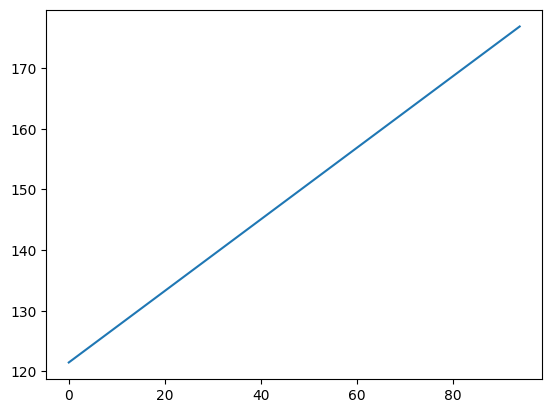

In [23]:
vals = []

sigma = lambda x: 1/(1 + np.exp(-2*.1*(x - 30)))

for phi in np.linspace(0.01, 1, 100)[5:]:
# for phi in list(rotation_log.keys()):
    kernel = (base_kernel  + additive_kernel_fun(phi))
    rightside = kernel[len(kernel)//2:]
    leftside = kernel[:len(kernel)//2]
    # vals.append(
    #     np.abs(
    #         rightside - leftside
    #     ).sum()
    # )
    vals.append(
        np.abs(
            10*ex_kernel * (- 3*(base_kernel  + additive_kernel_fun(phi)))
        ).sum()
    )

vals = np.array(vals)

plt.plot(vals)

In [24]:
from bbtoolkit.utils.datautils import read_pkl


rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)

times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

In [40]:
0.002*np.array(times[::-1])[0], (1/np.array(vals))[0], 0.002*np.array(times[::-1])[0]/(1/np.array(vals))[0]

(8.950000000000001, 0.7256279955707181, 12.334143741188875)

In [61]:
ex_kernel.sum()/base_kernel.sum()


0.16681044500560785

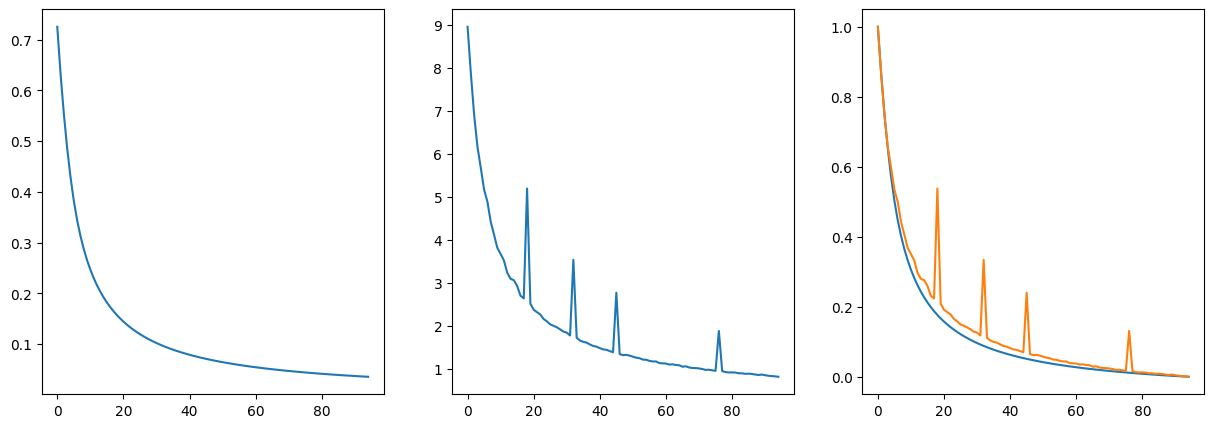

In [57]:
vals = []
for phi in np.linspace(0.01, 1, 100)[5:]:
    kernel = (base_kernel  + additive_kernel_fun(phi))
    midpoint = kernel[len(kernel)//2]
    first_half = kernel[:len(kernel)//2]
    second_half = kernel[-len(kernel)//2:]
    second_half_mirrored = second_half[::-1]
    difference_measure = np.sum(np.abs(first_half - second_half_mirrored))
    vals.append(difference_measure)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(1/np.array(vals))
ax2.plot(0.002*np.array(times[::-1]))
ax3.plot(rescale(1/np.array(vals)))
ax3.plot(rescale(times)[::-1])

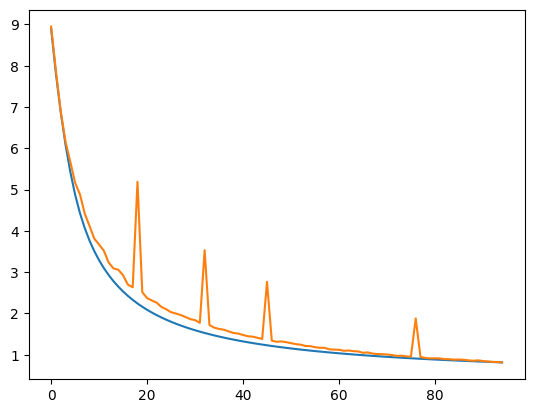

In [55]:
plt.plot(11.7*(1/np.array(vals)) + .4)
plt.plot(0.002*np.array(times[::-1]))

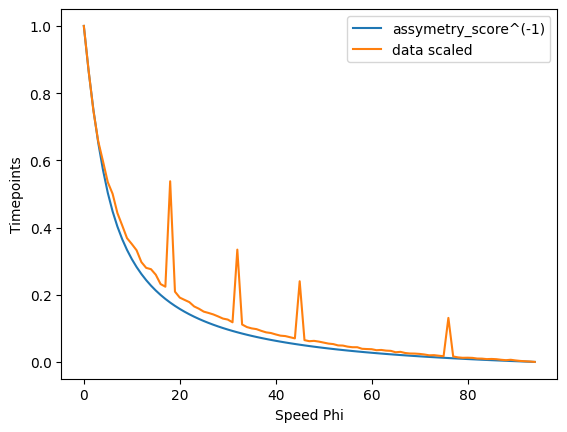

In [23]:
vals = []
# for phi in np.linspace(0.01, 1, 100)[5:]:
for phi in list(rotation_log.keys())[::-1]:
    kernel = base_kernel  + additive_kernel_fun(phi)
    midpoint = kernel[len(kernel)//2]
    first_half = kernel[:len(kernel)//2]
    second_half = kernel[-len(kernel)//2:]
    second_half_mirrored = second_half[::-1]
    difference_measure = np.mean(np.abs(first_half - second_half_mirrored))
    vals.append(difference_measure)

plt.plot(rescale(1/np.array(vals)))
plt.plot(rescale(times)[::-1])
plt.xlabel('Speed Phi')
plt.ylabel('Timepoints')
plt.legend([
    'assymetry_score^(-1)',
    'data scaled'
])

In [21]:
0.002*np.array(times[::-1])[0], 0.002*np.array(times[::-1])[-1]

(8.950000000000001, 0.812)

In [22]:
((1/np.array(vals)))[0], ((1/np.array(vals)))[-1]

(36.2813997785359, 1.771438998057063)

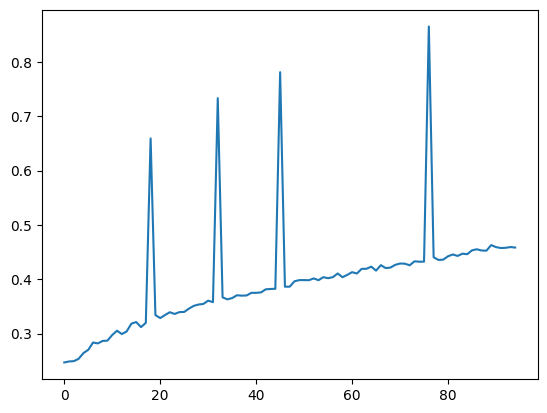

In [118]:
plt.plot(0.002*np.array(times[::-1])/((1/np.array(vals))))

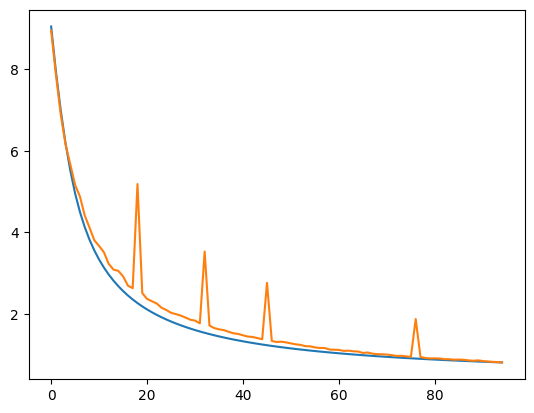

In [111]:
plt.plot((1/np.array(vals))/(np.pi*4/3) + .39)
plt.plot(0.002*np.array(times[::-1]))

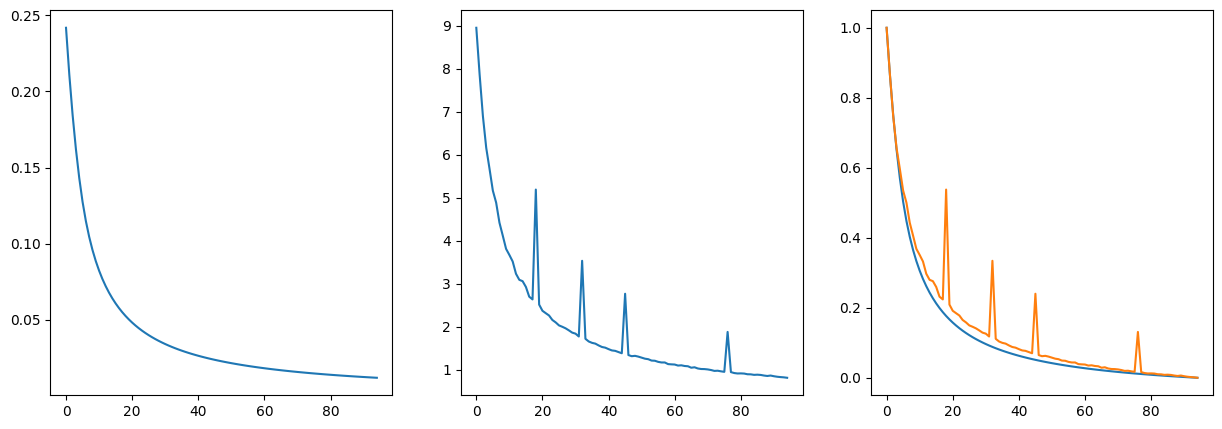

In [57]:
vals = []
for phi in np.linspace(0.01, 1, 100)[5:]:
    kernel = -3*(base_kernel  + additive_kernel_fun(phi))
    midpoint = kernel[len(kernel)//2]
    first_half = kernel[:len(kernel)//2]
    second_half = kernel[-len(kernel)//2:]
    second_half_mirrored = second_half[::-1]
    difference_measure = np.sum(np.abs(first_half - second_half_mirrored))
    vals.append(difference_measure)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(1/np.array(vals))
ax2.plot(0.002*np.array(times[::-1]))
ax3.plot(rescale(1/np.array(vals)))
ax3.plot(rescale(times)[::-1])

In [19]:
vals = []
for phi in np.linspace(0.01, 1, 100)[5:]:
    kernel = -3*(base_kernel  + additive_kernel_fun(phi))
    midpoint = kernel[len(kernel)//2]
    first_half = kernel[:len(kernel)//2]
    second_half = kernel[-len(kernel)//2:]
    second_half_mirrored = second_half[::-1]
    difference_measure = np.sum(np.abs(first_half - second_half_mirrored))
    vals.append(difference_measure)

plt.plot(rescale(1/np.array(vals)))
plt.plot(rescale(times)[::-1])

NameError: name 'rescale' is not defined

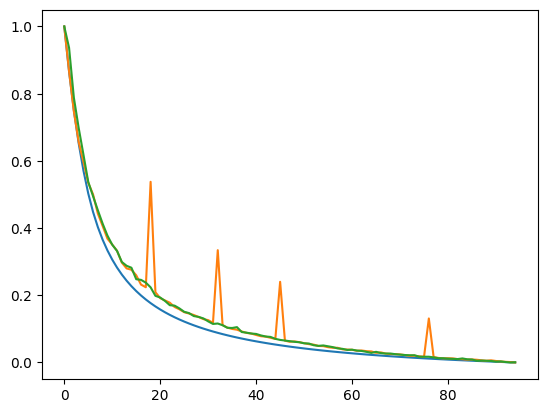

In [103]:
vals = []
for phi in np.linspace(0.01, 1, 100)[5:]:
    kernel = -3*(base_kernel  + additive_kernel_fun(phi))
    midpoint = kernel[len(kernel)//2]
    first_half = kernel[:len(kernel)//2]
    second_half = kernel[-len(kernel)//2:]
    second_half_mirrored = second_half[::-1]
    difference_measure = np.sum(np.abs(first_half - second_half_mirrored))
    vals.append(difference_measure)

plt.plot(rescale(1/np.array(vals)))
plt.plot(rescale(times)[::-1])
plt.plot(rescale(times2)[::-1])

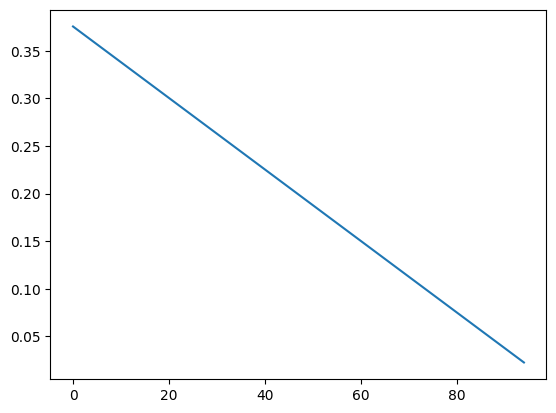

In [16]:
base_kernel = (
    gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
    gaussian_kernel_1d(100, center=0.8, sigma=0.15)
)

ex_kernel = gaussian_kernel_1d(100, center=0.5, sigma=0.05)

additive_kernel_fun =  lambda phi: phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15)

sigma = lambda x: 1/(1 + np.exp(-2*.1*(x - 60)))


vals = list()
# for phi in np.linspace(1, .01, 100)[:95]:
for phi in list(rotation_log.keys()):
    vals.append(
        # (base_kernel + additive_kernel_fun(phi)).sum()
        # np.abs(
        #     base_kernel - (base_kernel + additive_kernel_fun(phi))
        # ).mean()
        np.abs(
            (ex_kernel - (base_kernel + additive_kernel_fun(phi))) - (ex_kernel - base_kernel)
        ).mean()
    )

vals = np.array(vals)
plt.plot(vals)

# plt.plot(sigma(np.array(vals)))

In [87]:
times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

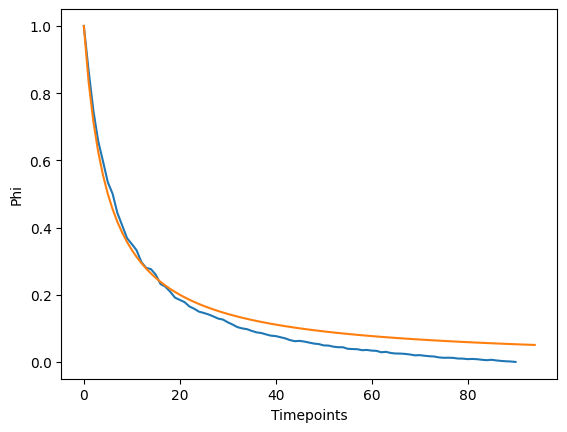

In [377]:
plt.plot(remove_indices(rescale(times), [18, 49, 62, 76])[::-1])
plt.ylabel('Phi')
plt.xlabel('Timepoints')
t = np.arange(95)
plt.plot(t, 1/(.2*t + 1))

In [15]:
def remove_indices(arr, indices):
    """
    Remove elements from a numpy array at specified indices.
    
    Parameters:
    - arr: Numpy array from which elements will be removed.
    - indices: A set of indices indicating which elements to remove.
    
    Returns:
    - A new numpy array with the specified elements removed.
    """
    # Ensure indices is a set to avoid duplicates
    indices_to_remove = set(indices)
    # Create a mask for all elements that are not in indices_to_remove
    mask = np.array([i not in indices_to_remove for i in range(len(arr))])
    # Return the array with elements at the specified indices removed
    return arr[mask]

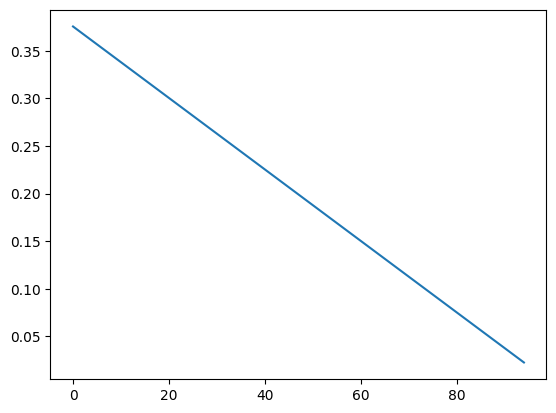

In [189]:
plt.plot(vals)

In [216]:
def random_like(matrix):
    return np.random.rand(*matrix.shape)

import random

def random_walk(n):
    # Initialize the starting point
    position = 0
    walk = [position]
    
    # Generate the walk
    for _ in range(n):
        step = random.choice([-1, 1])
        position += step
        walk.append(position)
    
    return np.array(walk)

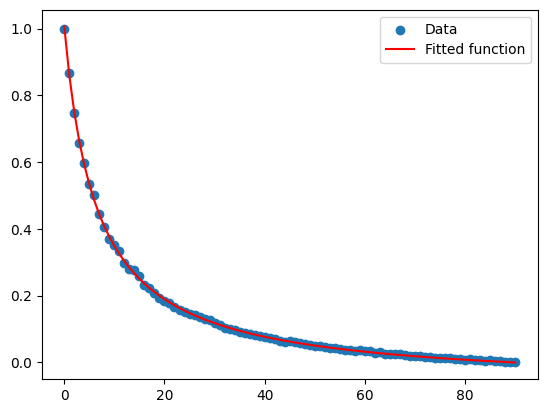

The fitted function is: f(x) = -543.9641931528103*x**3 + -78.87480015932174*x**2 + -504.61547324934355*x**1 + -0.07184889484204816


In [397]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a candidate function to fit
# For example, a polynomial function of degree 2
def poly_func2(x, a, b, c):
    return a * x**2 + b * x + c

def poly_func3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def poly_func4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def poly_func5(x, a, b, c, d, e, f):
    return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f

def poly_func6(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

def poly_func7(x, a, b, c, d, e, f, g, h):
    return a * x**7 + b * x**6 + c * x**5 + d * x**4 + e * x**3 + f * x**2 + g * x + h

def poly_func8(x, a, b, c, d, e, f, g, h, i):
    return a * x**8 + b * x**7 + c * x**6 + d * x**5 + e * x**4 + f * x**3 + g * x**2 + h * x + i

def exp_func(x, a, b, c, d):
    return a * np.exp(b * x + c) + d

def hip_func(x, a, b, c, d):
    return a/(b*x + c) + d



# Example data
Y = np.array(times)  # Your numpy vector
Y = remove_indices(Y, [18, 49, 62, 76])
Y = Y[::-1]
Y = rescale(Y)
# x = remove_indices(vals, [18, 49, 62, 76])
x = np.arange(len(Y))


func = hip_func

# Fit the function to your data
params, covariance = curve_fit(func, x, Y)

# Plot the original data and the fitted function
plt.scatter(x, Y, label='Data')
plt.plot(x, func(x, *params), label='Fitted function', color='red')

plt.legend()
plt.show()

# Print the found parameters
# print(f"The fitted function is: f(x) = {params[0]}*x^2 + {params[1]}*x + {params[2]}")
string = 'The fitted function is: f(x) = '
for i, param in enumerate(params):
    if i < len(params) - 1:
        string += f'{param}*x**{len(params) - i - 1} + '
    else:
        string += f'{param}'

print(string)


In [395]:
for p in params:
    print(p)

-543.9641931528103
-78.87480015932174
-504.61547324934355
-0.07184889484204816


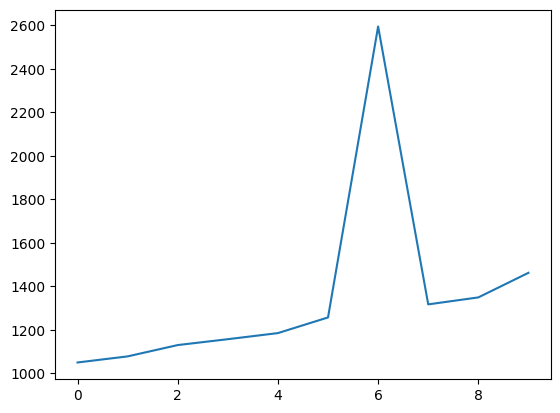

In [177]:
plt.plot(
    Y[70:80]
)

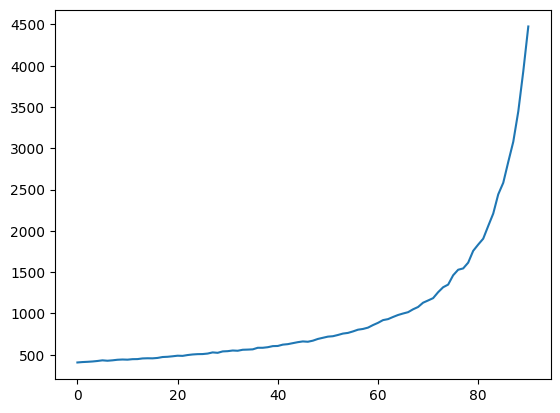

In [184]:
plt.plot(remove_indices(Y, [18, 49, 62, 76]))

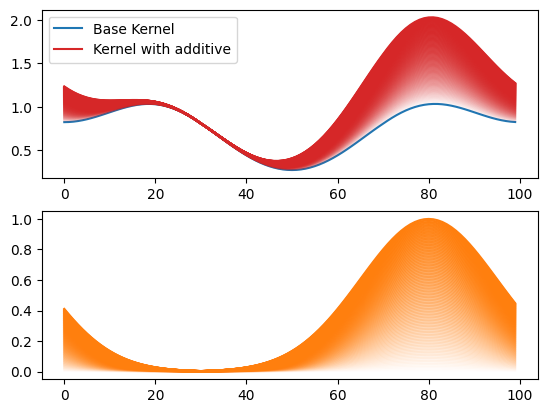

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(
    base_kernel
)
for phi in np.linspace(1, .01, 100):
    ax1.plot(
        base_kernel + additive_kernel_fun(phi),
        alpha=phi,
        color='tab:red'
    )

    ax2.plot(
        np.abs(
            base_kernel - (base_kernel + additive_kernel_fun(phi))
        ),
        alpha=phi,
        color='tab:orange'
    )

ax1.legend(['Base Kernel', 'Kernel with additive'])

In [91]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters
from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib qt

dt = .005

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache.connectivity.hd_ring1.to.hd_ring2['phi'] = -3
cache.connectivity.hd_ring2.to.hd_ring1['phi'] = 10
cache['simulation_params'] = DotDict(finished=False)


dynamics = DynamicsManager(
    dt,
    callbacks=[
        HDCallback(
            LoopAttractor(
                (
                    gaussian_kernel_1d(100, center=0.5, sigma=0.05)[None, :],
                    (
                        gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                        gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    )[None, :]
                )
            ),
            init_timesteps=100
        ),
        RotationAdjustingCallback(
            init_timesteps=100
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(lambda steps_per_cycle: not cache.simulation_params.finished):
    print('out: ', _)

2024-06-27 15:16:29 - DEBUG - Loaded backend qtagg version 6.7.0.
2024-06-27 15:16:30 - DEBUG - HD CUE INITIATED
2024-06-27 15:16:35 - DEBUG - HD CUE REMOVED
2024-06-27 15:16:35 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:16:35 - DEBUG - Testing speed phi: 1.0


out:  (None, None, None, None)


2024-06-27 15:16:42 - DEBUG - Full circle is complete: 0.8150000000000001; Resetting head direction cue
2024-06-27 15:16:42 - DEBUG - HD CUE INITIATED
2024-06-27 15:16:46 - DEBUG - HD CUE REMOVED
2024-06-27 15:16:46 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:16:46 - DEBUG - Testing speed phi: 0.99


out:  (None, None, None, None)


2024-06-27 15:16:52 - DEBUG - Full circle is complete: 0.81; Resetting head direction cue
2024-06-27 15:16:52 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:16:56 - DEBUG - HD CUE REMOVED
2024-06-27 15:16:56 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:16:56 - DEBUG - Testing speed phi: 0.98
2024-06-27 15:17:03 - DEBUG - Full circle is complete: 0.8200000000000001; Resetting head direction cue
2024-06-27 15:17:03 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:17:07 - DEBUG - HD CUE REMOVED
2024-06-27 15:17:07 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:17:07 - DEBUG - Testing speed phi: 0.97


out:  (None, None, None, None)


2024-06-27 15:17:14 - DEBUG - Full circle is complete: 0.835; Resetting head direction cue
2024-06-27 15:17:14 - DEBUG - HD CUE INITIATED
2024-06-27 15:17:18 - DEBUG - HD CUE REMOVED
2024-06-27 15:17:18 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:17:18 - DEBUG - Testing speed phi: 0.96


out:  (None, None, None, None)


2024-06-27 15:17:26 - DEBUG - Full circle is complete: 0.8300000000000001; Resetting head direction cue
2024-06-27 15:17:26 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:17:30 - DEBUG - HD CUE REMOVED
2024-06-27 15:17:30 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:17:30 - DEBUG - Testing speed phi: 0.9500000000000001
2024-06-27 15:17:38 - DEBUG - Full circle is complete: 0.845; Resetting head direction cue
2024-06-27 15:17:38 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:17:42 - DEBUG - HD CUE REMOVED
2024-06-27 15:17:42 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:17:42 - DEBUG - Testing speed phi: 0.9400000000000001


out:  (None, None, None, None)


2024-06-27 15:17:50 - DEBUG - Full circle is complete: 0.85; Resetting head direction cue
2024-06-27 15:17:50 - DEBUG - HD CUE INITIATED
2024-06-27 15:17:54 - DEBUG - HD CUE REMOVED
2024-06-27 15:17:54 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:17:54 - DEBUG - Testing speed phi: 0.93


out:  (None, None, None, None)


2024-06-27 15:18:02 - DEBUG - Full circle is complete: 0.855; Resetting head direction cue
2024-06-27 15:18:02 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:18:06 - DEBUG - HD CUE REMOVED
2024-06-27 15:18:06 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:18:06 - DEBUG - Testing speed phi: 0.92


out:  (None, None, None, None)


2024-06-27 15:18:14 - DEBUG - Full circle is complete: 0.85; Resetting head direction cue
2024-06-27 15:18:14 - DEBUG - HD CUE INITIATED
2024-06-27 15:18:19 - DEBUG - HD CUE REMOVED
2024-06-27 15:18:19 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:18:19 - DEBUG - Testing speed phi: 0.91


out:  (None, None, None, None)


2024-06-27 15:18:27 - DEBUG - Full circle is complete: 0.88; Resetting head direction cue
2024-06-27 15:18:27 - DEBUG - HD CUE INITIATED
2024-06-27 15:18:31 - DEBUG - HD CUE REMOVED
2024-06-27 15:18:31 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:18:31 - DEBUG - Testing speed phi: 0.9


out:  (None, None, None, None)


2024-06-27 15:18:40 - DEBUG - Full circle is complete: 0.885; Resetting head direction cue
2024-06-27 15:18:40 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:18:45 - DEBUG - HD CUE REMOVED
2024-06-27 15:18:45 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:18:45 - DEBUG - Testing speed phi: 0.89


out:  (None, None, None, None)


2024-06-27 15:18:53 - DEBUG - Full circle is complete: 0.905; Resetting head direction cue
2024-06-27 15:18:53 - DEBUG - HD CUE INITIATED
2024-06-27 15:18:58 - DEBUG - HD CUE REMOVED
2024-06-27 15:18:58 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:18:58 - DEBUG - Testing speed phi: 0.88


out:  (None, None, None, None)


2024-06-27 15:19:06 - DEBUG - Full circle is complete: 0.89; Resetting head direction cue
2024-06-27 15:19:06 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:19:11 - DEBUG - HD CUE REMOVED
2024-06-27 15:19:11 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:19:11 - DEBUG - Testing speed phi: 0.87


out:  (None, None, None, None)


2024-06-27 15:19:19 - DEBUG - Full circle is complete: 0.895; Resetting head direction cue
2024-06-27 15:19:19 - DEBUG - HD CUE INITIATED
2024-06-27 15:19:24 - DEBUG - HD CUE REMOVED
2024-06-27 15:19:24 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:19:24 - DEBUG - Testing speed phi: 0.86


out:  (None, None, None, None)


2024-06-27 15:19:33 - DEBUG - Full circle is complete: 0.9; Resetting head direction cue
2024-06-27 15:19:33 - DEBUG - HD CUE INITIATED
2024-06-27 15:19:37 - DEBUG - HD CUE REMOVED
2024-06-27 15:19:37 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:19:37 - DEBUG - Testing speed phi: 0.85


out:  (None, None, None, None)


2024-06-27 15:19:47 - DEBUG - Full circle is complete: 0.91; Resetting head direction cue
2024-06-27 15:19:47 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:19:52 - DEBUG - HD CUE REMOVED
2024-06-27 15:19:52 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:19:52 - DEBUG - Testing speed phi: 0.84


out:  (None, None, None, None)


2024-06-27 15:20:01 - DEBUG - Full circle is complete: 0.91; Resetting head direction cue
2024-06-27 15:20:01 - DEBUG - HD CUE INITIATED
2024-06-27 15:20:07 - DEBUG - HD CUE REMOVED
2024-06-27 15:20:07 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:20:07 - DEBUG - Testing speed phi: 0.8300000000000001


out:  (None, None, None, None)


2024-06-27 15:20:17 - DEBUG - Full circle is complete: 0.93; Resetting head direction cue
2024-06-27 15:20:17 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:20:22 - DEBUG - HD CUE REMOVED
2024-06-27 15:20:22 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:20:22 - DEBUG - Testing speed phi: 0.8200000000000001


out:  (None, None, None, None)


2024-06-27 15:20:32 - DEBUG - Full circle is complete: 0.9450000000000001; Resetting head direction cue
2024-06-27 15:20:32 - DEBUG - HD CUE INITIATED
2024-06-27 15:20:37 - DEBUG - HD CUE REMOVED
2024-06-27 15:20:37 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:20:37 - DEBUG - Testing speed phi: 0.81


out:  (None, None, None, None)


2024-06-27 15:20:47 - DEBUG - Full circle is complete: 0.9450000000000001; Resetting head direction cue
2024-06-27 15:20:47 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:20:53 - DEBUG - HD CUE REMOVED
2024-06-27 15:20:53 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:20:53 - DEBUG - Testing speed phi: 0.8


out:  (None, None, None, None)


2024-06-27 15:21:03 - DEBUG - Full circle is complete: 0.9450000000000001; Resetting head direction cue
2024-06-27 15:21:03 - DEBUG - HD CUE INITIATED
2024-06-27 15:21:08 - DEBUG - HD CUE REMOVED
2024-06-27 15:21:08 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:21:08 - DEBUG - Testing speed phi: 0.79


out:  (None, None, None, None)


2024-06-27 15:21:18 - DEBUG - Full circle is complete: 0.98; Resetting head direction cue
2024-06-27 15:21:18 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:21:23 - DEBUG - HD CUE REMOVED
2024-06-27 15:21:23 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:21:23 - DEBUG - Testing speed phi: 0.78
2024-06-27 15:21:33 - DEBUG - Full circle is complete: 0.98; Resetting head direction cue


out:  (None, None, None, None)


2024-06-27 15:21:33 - DEBUG - HD CUE INITIATED
2024-06-27 15:21:37 - DEBUG - HD CUE REMOVED
2024-06-27 15:21:37 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:21:37 - DEBUG - Testing speed phi: 0.77


out:  (None, None, None, None)


2024-06-27 15:21:46 - DEBUG - Full circle is complete: 0.985; Resetting head direction cue
2024-06-27 15:21:46 - DEBUG - HD CUE INITIATED
2024-06-27 15:21:50 - DEBUG - HD CUE REMOVED
2024-06-27 15:21:50 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:21:50 - DEBUG - Testing speed phi: 0.76


out:  (None, None, None, None)


2024-06-27 15:21:58 - DEBUG - Full circle is complete: 0.995; Resetting head direction cue
2024-06-27 15:21:58 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:22:03 - DEBUG - HD CUE REMOVED
2024-06-27 15:22:03 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:22:03 - DEBUG - Testing speed phi: 0.75


out:  (None, None, None, None)


2024-06-27 15:22:11 - DEBUG - Full circle is complete: 1.0050000000000001; Resetting head direction cue
2024-06-27 15:22:11 - DEBUG - HD CUE INITIATED
2024-06-27 15:22:15 - DEBUG - HD CUE REMOVED
2024-06-27 15:22:15 - DEBUG - Head direction cue set; New kernel function created


out:  (None, None, None, None)


2024-06-27 15:22:15 - DEBUG - Testing speed phi: 0.74
2024-06-27 15:22:24 - DEBUG - Full circle is complete: 1.02; Resetting head direction cue


out:  (None, None, None, None)


2024-06-27 15:22:24 - DEBUG - HD CUE INITIATED
2024-06-27 15:22:28 - DEBUG - HD CUE REMOVED
2024-06-27 15:22:28 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:22:28 - DEBUG - Testing speed phi: 0.73


out:  (None, None, None, None)


2024-06-27 15:22:39 - DEBUG - Full circle is complete: 1.02; Resetting head direction cue
2024-06-27 15:22:39 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:22:44 - DEBUG - HD CUE REMOVED
2024-06-27 15:22:44 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:22:44 - DEBUG - Testing speed phi: 0.72


out:  (None, None, None, None)


2024-06-27 15:22:54 - DEBUG - Full circle is complete: 1.03; Resetting head direction cue
2024-06-27 15:22:54 - DEBUG - HD CUE INITIATED
2024-06-27 15:22:59 - DEBUG - HD CUE REMOVED
2024-06-27 15:22:59 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:22:59 - DEBUG - Testing speed phi: 0.71


out:  (None, None, None, None)


2024-06-27 15:23:09 - DEBUG - Full circle is complete: 1.06; Resetting head direction cue
2024-06-27 15:23:09 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:23:14 - DEBUG - HD CUE REMOVED
2024-06-27 15:23:14 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:23:14 - DEBUG - Testing speed phi: 0.7000000000000001


out:  (None, None, None, None)


2024-06-27 15:23:24 - DEBUG - Full circle is complete: 1.035; Resetting head direction cue
2024-06-27 15:23:24 - DEBUG - HD CUE INITIATED
2024-06-27 15:23:29 - DEBUG - HD CUE REMOVED
2024-06-27 15:23:29 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:23:29 - DEBUG - Testing speed phi: 0.6900000000000001


out:  (None, None, None, None)


2024-06-27 15:23:40 - DEBUG - Full circle is complete: 1.06; Resetting head direction cue
2024-06-27 15:23:40 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:23:45 - DEBUG - HD CUE REMOVED
2024-06-27 15:23:45 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:23:45 - DEBUG - Testing speed phi: 0.68


out:  (None, None, None, None)


2024-06-27 15:23:56 - DEBUG - Full circle is complete: 1.08; Resetting head direction cue
2024-06-27 15:23:56 - DEBUG - HD CUE INITIATED
2024-06-27 15:24:01 - DEBUG - HD CUE REMOVED
2024-06-27 15:24:01 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:24:01 - DEBUG - Testing speed phi: 0.67


out:  (None, None, None, None)


2024-06-27 15:24:12 - DEBUG - Full circle is complete: 1.09; Resetting head direction cue
2024-06-27 15:24:12 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:24:17 - DEBUG - HD CUE REMOVED
2024-06-27 15:24:17 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:24:17 - DEBUG - Testing speed phi: 0.66


out:  (None, None, None, None)


2024-06-27 15:24:28 - DEBUG - Full circle is complete: 1.11; Resetting head direction cue
2024-06-27 15:24:28 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:24:33 - DEBUG - HD CUE REMOVED
2024-06-27 15:24:33 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:24:33 - DEBUG - Testing speed phi: 0.65


out:  (None, None, None, None)


2024-06-27 15:24:44 - DEBUG - Full circle is complete: 1.105; Resetting head direction cue
2024-06-27 15:24:44 - DEBUG - HD CUE INITIATED
2024-06-27 15:24:49 - DEBUG - HD CUE REMOVED
2024-06-27 15:24:49 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:24:49 - DEBUG - Testing speed phi: 0.64


out:  (None, None, None, None)


2024-06-27 15:25:00 - DEBUG - Full circle is complete: 1.1300000000000001; Resetting head direction cue
2024-06-27 15:25:00 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:25:06 - DEBUG - HD CUE REMOVED
2024-06-27 15:25:06 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:25:06 - DEBUG - Testing speed phi: 0.63


out:  (None, None, None, None)


2024-06-27 15:25:17 - DEBUG - Full circle is complete: 1.1400000000000001; Resetting head direction cue
2024-06-27 15:25:17 - DEBUG - HD CUE INITIATED
2024-06-27 15:25:22 - DEBUG - HD CUE REMOVED
2024-06-27 15:25:22 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:25:22 - DEBUG - Testing speed phi: 0.62


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:25:33 - DEBUG - Full circle is complete: 1.17; Resetting head direction cue
2024-06-27 15:25:33 - DEBUG - HD CUE INITIATED
2024-06-27 15:25:38 - DEBUG - HD CUE REMOVED
2024-06-27 15:25:38 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:25:38 - DEBUG - Testing speed phi: 0.61


out:  (None, None, None, None)


2024-06-27 15:25:50 - DEBUG - Full circle is complete: 1.19; Resetting head direction cue
2024-06-27 15:25:50 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:25:55 - DEBUG - HD CUE REMOVED
2024-06-27 15:25:55 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:25:55 - DEBUG - Testing speed phi: 0.6


out:  (None, None, None, None)


2024-06-27 15:26:07 - DEBUG - Full circle is complete: 1.21; Resetting head direction cue
2024-06-27 15:26:07 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:26:12 - DEBUG - HD CUE REMOVED
2024-06-27 15:26:12 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:26:12 - DEBUG - Testing speed phi: 0.59


out:  (None, None, None, None)


2024-06-27 15:26:23 - DEBUG - Full circle is complete: 1.2; Resetting head direction cue
2024-06-27 15:26:23 - DEBUG - HD CUE INITIATED
2024-06-27 15:26:28 - DEBUG - HD CUE REMOVED
2024-06-27 15:26:28 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:26:28 - DEBUG - Testing speed phi: 0.58


out:  (None, None, None, None)


2024-06-27 15:26:40 - DEBUG - Full circle is complete: 1.215; Resetting head direction cue
2024-06-27 15:26:40 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:26:45 - DEBUG - HD CUE REMOVED
2024-06-27 15:26:45 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:26:45 - DEBUG - Testing speed phi: 0.5700000000000001


out:  (None, None, None, None)


2024-06-27 15:26:58 - DEBUG - Full circle is complete: 1.2550000000000001; Resetting head direction cue
2024-06-27 15:26:58 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:27:03 - DEBUG - HD CUE REMOVED
2024-06-27 15:27:03 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:27:03 - DEBUG - Testing speed phi: 0.56


out:  (None, None, None, None)


2024-06-27 15:27:15 - DEBUG - Full circle is complete: 1.26; Resetting head direction cue
2024-06-27 15:27:15 - DEBUG - HD CUE INITIATED
2024-06-27 15:27:20 - DEBUG - HD CUE REMOVED
2024-06-27 15:27:20 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:27:20 - DEBUG - Testing speed phi: 0.55


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:27:31 - DEBUG - Full circle is complete: 1.285; Resetting head direction cue
2024-06-27 15:27:31 - DEBUG - HD CUE INITIATED
2024-06-27 15:27:36 - DEBUG - HD CUE REMOVED
2024-06-27 15:27:36 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:27:36 - DEBUG - Testing speed phi: 0.54


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:27:49 - DEBUG - Full circle is complete: 1.295; Resetting head direction cue
2024-06-27 15:27:49 - DEBUG - HD CUE INITIATED
2024-06-27 15:27:53 - DEBUG - HD CUE REMOVED
2024-06-27 15:27:53 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:27:53 - DEBUG - Testing speed phi: 0.53


out:  (None, None, None, None)


2024-06-27 15:28:07 - DEBUG - Full circle is complete: 1.31; Resetting head direction cue
2024-06-27 15:28:07 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:28:12 - DEBUG - HD CUE REMOVED
2024-06-27 15:28:12 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:28:12 - DEBUG - Testing speed phi: 0.52


out:  (None, None, None, None)


2024-06-27 15:28:25 - DEBUG - Full circle is complete: 1.325; Resetting head direction cue
2024-06-27 15:28:25 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:28:29 - DEBUG - HD CUE REMOVED
2024-06-27 15:28:29 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:28:29 - DEBUG - Testing speed phi: 0.51


out:  (None, None, None, None)


2024-06-27 15:28:44 - DEBUG - Full circle is complete: 1.34; Resetting head direction cue
2024-06-27 15:28:44 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:28:48 - DEBUG - HD CUE REMOVED
2024-06-27 15:28:48 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:28:48 - DEBUG - Testing speed phi: 0.5


out:  (None, None, None, None)


2024-06-27 15:29:02 - DEBUG - Full circle is complete: 1.365; Resetting head direction cue
2024-06-27 15:29:02 - DEBUG - HD CUE INITIATED
2024-06-27 15:29:07 - DEBUG - HD CUE REMOVED
2024-06-27 15:29:07 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:29:07 - DEBUG - Testing speed phi: 0.49


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:29:21 - DEBUG - Full circle is complete: 1.41; Resetting head direction cue
2024-06-27 15:29:21 - DEBUG - HD CUE INITIATED
2024-06-27 15:29:25 - DEBUG - HD CUE REMOVED
2024-06-27 15:29:25 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:29:25 - DEBUG - Testing speed phi: 0.48


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:29:40 - DEBUG - Full circle is complete: 1.42; Resetting head direction cue
2024-06-27 15:29:40 - DEBUG - HD CUE INITIATED
2024-06-27 15:29:45 - DEBUG - HD CUE REMOVED
2024-06-27 15:29:45 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:29:45 - DEBUG - Testing speed phi: 0.47000000000000003


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:30:00 - DEBUG - Full circle is complete: 1.445; Resetting head direction cue
2024-06-27 15:30:00 - DEBUG - HD CUE INITIATED
2024-06-27 15:30:05 - DEBUG - HD CUE REMOVED
2024-06-27 15:30:05 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:30:05 - DEBUG - Testing speed phi: 0.46


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:30:19 - DEBUG - Full circle is complete: 1.48; Resetting head direction cue
2024-06-27 15:30:20 - DEBUG - HD CUE INITIATED
2024-06-27 15:30:24 - DEBUG - HD CUE REMOVED
2024-06-27 15:30:24 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:30:24 - DEBUG - Testing speed phi: 0.45


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:30:39 - DEBUG - Full circle is complete: 1.49; Resetting head direction cue
2024-06-27 15:30:39 - DEBUG - HD CUE INITIATED
2024-06-27 15:30:44 - DEBUG - HD CUE REMOVED
2024-06-27 15:30:44 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:30:44 - DEBUG - Testing speed phi: 0.44


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:30:59 - DEBUG - Full circle is complete: 1.51; Resetting head direction cue
2024-06-27 15:30:59 - DEBUG - HD CUE INITIATED
2024-06-27 15:31:04 - DEBUG - HD CUE REMOVED
2024-06-27 15:31:04 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:31:04 - DEBUG - Testing speed phi: 0.43


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:31:19 - DEBUG - Full circle is complete: 1.5250000000000001; Resetting head direction cue
2024-06-27 15:31:19 - DEBUG - HD CUE INITIATED
2024-06-27 15:31:24 - DEBUG - HD CUE REMOVED
2024-06-27 15:31:24 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:31:24 - DEBUG - Testing speed phi: 0.42


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:31:41 - DEBUG - Full circle is complete: 1.6400000000000001; Resetting head direction cue
2024-06-27 15:31:41 - DEBUG - HD CUE INITIATED
2024-06-27 15:31:46 - DEBUG - HD CUE REMOVED
2024-06-27 15:31:46 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:31:46 - DEBUG - Testing speed phi: 0.41000000000000003


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:32:03 - DEBUG - Full circle is complete: 1.62; Resetting head direction cue
2024-06-27 15:32:03 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:32:08 - DEBUG - HD CUE REMOVED
2024-06-27 15:32:08 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:32:08 - DEBUG - Testing speed phi: 0.4


out:  (None, None, None, None)


2024-06-27 15:32:24 - DEBUG - Full circle is complete: 1.625; Resetting head direction cue
2024-06-27 15:32:24 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:32:29 - DEBUG - HD CUE REMOVED
2024-06-27 15:32:29 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:32:29 - DEBUG - Testing speed phi: 0.39


out:  (None, None, None, None)


2024-06-27 15:32:45 - DEBUG - Full circle is complete: 1.685; Resetting head direction cue
2024-06-27 15:32:45 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:32:50 - DEBUG - HD CUE REMOVED
2024-06-27 15:32:50 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:32:50 - DEBUG - Testing speed phi: 0.38


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:33:08 - DEBUG - Full circle is complete: 1.725; Resetting head direction cue
2024-06-27 15:33:08 - DEBUG - HD CUE INITIATED
2024-06-27 15:33:12 - DEBUG - HD CUE REMOVED
2024-06-27 15:33:12 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:33:12 - DEBUG - Testing speed phi: 0.37


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:33:29 - DEBUG - Full circle is complete: 1.715; Resetting head direction cue
2024-06-27 15:33:29 - DEBUG - HD CUE INITIATED
2024-06-27 15:33:34 - DEBUG - HD CUE REMOVED
2024-06-27 15:33:34 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:33:35 - DEBUG - Testing speed phi: 0.36


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:33:52 - DEBUG - Full circle is complete: 1.7750000000000001; Resetting head direction cue
2024-06-27 15:33:52 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:33:57 - DEBUG - HD CUE REMOVED
2024-06-27 15:33:57 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:33:57 - DEBUG - Testing speed phi: 0.35000000000000003


out:  (None, None, None, None)


2024-06-27 15:34:15 - DEBUG - Full circle is complete: 1.845; Resetting head direction cue
2024-06-27 15:34:15 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:34:21 - DEBUG - HD CUE REMOVED
2024-06-27 15:34:21 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:34:21 - DEBUG - Testing speed phi: 0.34


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:34:39 - DEBUG - Full circle is complete: 1.8800000000000001; Resetting head direction cue
2024-06-27 15:34:39 - DEBUG - HD CUE INITIATED
2024-06-27 15:34:44 - DEBUG - HD CUE REMOVED
2024-06-27 15:34:44 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:34:44 - DEBUG - Testing speed phi: 0.33


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:35:03 - DEBUG - Full circle is complete: 1.9000000000000001; Resetting head direction cue
2024-06-27 15:35:03 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:35:08 - DEBUG - HD CUE REMOVED
2024-06-27 15:35:08 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:35:08 - DEBUG - Testing speed phi: 0.32


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:35:28 - DEBUG - Full circle is complete: 1.97; Resetting head direction cue
2024-06-27 15:35:28 - DEBUG - HD CUE INITIATED
2024-06-27 15:35:33 - DEBUG - HD CUE REMOVED
2024-06-27 15:35:33 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:35:33 - DEBUG - Testing speed phi: 0.31


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:35:53 - DEBUG - Full circle is complete: 2.0; Resetting head direction cue
2024-06-27 15:35:53 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:35:58 - DEBUG - HD CUE REMOVED
2024-06-27 15:35:58 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:35:58 - DEBUG - Testing speed phi: 0.3


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:36:19 - DEBUG - Full circle is complete: 2.08; Resetting head direction cue
2024-06-27 15:36:19 - DEBUG - HD CUE INITIATED
2024-06-27 15:36:24 - DEBUG - HD CUE REMOVED
2024-06-27 15:36:24 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:36:24 - DEBUG - Testing speed phi: 0.29


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:36:45 - DEBUG - Full circle is complete: 2.145; Resetting head direction cue
2024-06-27 15:36:45 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:36:50 - DEBUG - HD CUE REMOVED
2024-06-27 15:36:50 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:36:50 - DEBUG - Testing speed phi: 0.28


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:37:12 - DEBUG - Full circle is complete: 2.1550000000000002; Resetting head direction cue
2024-06-27 15:37:12 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:37:17 - DEBUG - HD CUE REMOVED
2024-06-27 15:37:17 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:37:17 - DEBUG - Testing speed phi: 0.27


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:37:39 - DEBUG - Full circle is complete: 2.255; Resetting head direction cue
2024-06-27 15:37:39 - DEBUG - HD CUE INITIATED
2024-06-27 15:37:44 - DEBUG - HD CUE REMOVED
2024-06-27 15:37:44 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:37:44 - DEBUG - Testing speed phi: 0.26


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:38:08 - DEBUG - Full circle is complete: 2.335; Resetting head direction cue
2024-06-27 15:38:08 - DEBUG - HD CUE INITIATED
2024-06-27 15:38:13 - DEBUG - HD CUE REMOVED
2024-06-27 15:38:13 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:38:13 - DEBUG - Testing speed phi: 0.25


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:38:36 - DEBUG - Full circle is complete: 2.375; Resetting head direction cue
2024-06-27 15:38:36 - DEBUG - HD CUE INITIATED
2024-06-27 15:38:41 - DEBUG - HD CUE REMOVED
2024-06-27 15:38:41 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:38:41 - DEBUG - Testing speed phi: 0.24


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:39:07 - DEBUG - Full circle is complete: 2.575; Resetting head direction cue
2024-06-27 15:39:07 - DEBUG - HD CUE INITIATED
2024-06-27 15:39:12 - DEBUG - HD CUE REMOVED
2024-06-27 15:39:12 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:39:12 - DEBUG - Testing speed phi: 0.23


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:39:39 - DEBUG - Full circle is complete: 2.685; Resetting head direction cue
2024-06-27 15:39:40 - DEBUG - HD CUE INITIATED
2024-06-27 15:39:44 - DEBUG - HD CUE REMOVED
2024-06-27 15:39:44 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:39:44 - DEBUG - Testing speed phi: 0.22


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:40:12 - DEBUG - Full circle is complete: 2.75; Resetting head direction cue
2024-06-27 15:40:12 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:40:17 - DEBUG - HD CUE REMOVED
2024-06-27 15:40:17 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:40:17 - DEBUG - Testing speed phi: 0.21


out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:40:45 - DEBUG - Full circle is complete: 2.765; Resetting head direction cue
2024-06-27 15:40:45 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:40:51 - DEBUG - HD CUE REMOVED
2024-06-27 15:40:51 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:40:51 - DEBUG - Testing speed phi: 0.2


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:41:21 - DEBUG - Full circle is complete: 3.035; Resetting head direction cue
2024-06-27 15:41:21 - DEBUG - HD CUE INITIATED
2024-06-27 15:41:26 - DEBUG - HD CUE REMOVED
2024-06-27 15:41:26 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:41:26 - DEBUG - Testing speed phi: 0.19


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:41:56 - DEBUG - Full circle is complete: 3.08; Resetting head direction cue
2024-06-27 15:41:56 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:42:01 - DEBUG - HD CUE REMOVED
2024-06-27 15:42:01 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:42:01 - DEBUG - Testing speed phi: 0.18


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:42:32 - DEBUG - Full circle is complete: 3.17; Resetting head direction cue
2024-06-27 15:42:32 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:42:37 - DEBUG - HD CUE REMOVED
2024-06-27 15:42:37 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:42:37 - DEBUG - Testing speed phi: 0.17


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:43:10 - DEBUG - Full circle is complete: 3.43; Resetting head direction cue
2024-06-27 15:43:10 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:43:15 - DEBUG - HD CUE REMOVED
2024-06-27 15:43:15 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:43:15 - DEBUG - Testing speed phi: 0.16


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:43:51 - DEBUG - Full circle is complete: 3.575; Resetting head direction cue
2024-06-27 15:43:51 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:43:56 - DEBUG - HD CUE REMOVED
2024-06-27 15:43:56 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:43:56 - DEBUG - Testing speed phi: 0.15


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:44:33 - DEBUG - Full circle is complete: 3.79; Resetting head direction cue
2024-06-27 15:44:33 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:44:39 - DEBUG - HD CUE REMOVED
2024-06-27 15:44:39 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:44:39 - DEBUG - Testing speed phi: 0.14


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:45:19 - DEBUG - Full circle is complete: 4.07; Resetting head direction cue
2024-06-27 15:45:19 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:45:24 - DEBUG - HD CUE REMOVED
2024-06-27 15:45:24 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:45:24 - DEBUG - Testing speed phi: 0.13


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:46:07 - DEBUG - Full circle is complete: 4.385; Resetting head direction cue
2024-06-27 15:46:08 - DEBUG - HD CUE INITIATED
2024-06-27 15:46:12 - DEBUG - HD CUE REMOVED
2024-06-27 15:46:12 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:46:12 - DEBUG - Testing speed phi: 0.12


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:46:59 - DEBUG - Full circle is complete: 4.715; Resetting head direction cue
2024-06-27 15:46:59 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:47:04 - DEBUG - HD CUE REMOVED
2024-06-27 15:47:04 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:47:04 - DEBUG - Testing speed phi: 0.11


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:47:54 - DEBUG - Full circle is complete: 5.05; Resetting head direction cue
2024-06-27 15:47:54 - DEBUG - HD CUE INITIATED
2024-06-27 15:47:59 - DEBUG - HD CUE REMOVED
2024-06-27 15:47:59 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:47:59 - DEBUG - Testing speed phi: 0.1


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:48:56 - DEBUG - Full circle is complete: 5.69; Resetting head direction cue
2024-06-27 15:48:56 - DEBUG - HD CUE INITIATED
2024-06-27 15:49:01 - DEBUG - HD CUE REMOVED
2024-06-27 15:49:01 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:49:01 - DEBUG - Testing speed phi: 0.09


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:50:02 - DEBUG - Full circle is complete: 6.32; Resetting head direction cue
2024-06-27 15:50:02 - DEBUG - HD CUE INITIATED
2024-06-27 15:50:07 - DEBUG - HD CUE REMOVED
2024-06-27 15:50:07 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:50:07 - DEBUG - Testing speed phi: 0.08


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:51:18 - DEBUG - Full circle is complete: 7.03; Resetting head direction cue
2024-06-27 15:51:18 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:51:23 - DEBUG - HD CUE REMOVED
2024-06-27 15:51:23 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:51:23 - DEBUG - Testing speed phi: 0.07


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:52:45 - DEBUG - Full circle is complete: 8.2; Resetting head direction cue
2024-06-27 15:52:45 - DEBUG - HD CUE INITIATED
2024-06-27 15:52:50 - DEBUG - HD CUE REMOVED
2024-06-27 15:52:50 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:52:50 - DEBUG - Testing speed phi: 0.06


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:54:17 - DEBUG - Full circle is complete: 8.700000000000001; Resetting head direction cue
2024-06-27 15:54:17 - DEBUG - HD CUE INITIATED


out:  (None, None, None, None)


2024-06-27 15:54:22 - DEBUG - HD CUE REMOVED
2024-06-27 15:54:22 - DEBUG - Head direction cue set; New kernel function created
2024-06-27 15:54:22 - DEBUG - Testing speed phi: 0.05


out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)
out:  (None, None, None, None)


2024-06-27 15:56:02 - DEBUG - Speed phi is too slow (slower that 2*π/10); Removing records and interupting the simulation...
2024-06-27 15:56:02 - DEBUG - All speed phis have been tested; Simulation will be completed at the end of the current cycle...
2024-06-27 15:56:02 - DEBUG - Simulation was interrupted due to: StopIteration()


In [12]:
dynamics.save('../data/dynamics/rotation_adjust_sim.pkl')

AttributeError: Can't pickle local object 'RotationAdjustingCallback.set_cache.<locals>.<lambda>'

In [14]:
cache.rotation_log[1]

{'time': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 

In [99]:
from bbtoolkit.utils.datautils import save_pkl


save_pkl(cache.rotation_log, '../data/dynamics/rotation_log2.pkl')

In [5]:
from bbtoolkit.utils.datautils import read_pkl


rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)

In [8]:
times2, phis2 = [], []
for key in rotation_log2:
    times2.append(len(rotation_log2[key].time))
    phis2.append(key)

In [7]:
times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

In [6]:
rotation_log2 = read_pkl(
    '../data/dynamics/rotation_log2.pkl'
)

2024-06-28 15:45:42 - DEBUG - Loaded backend inline version unknown.


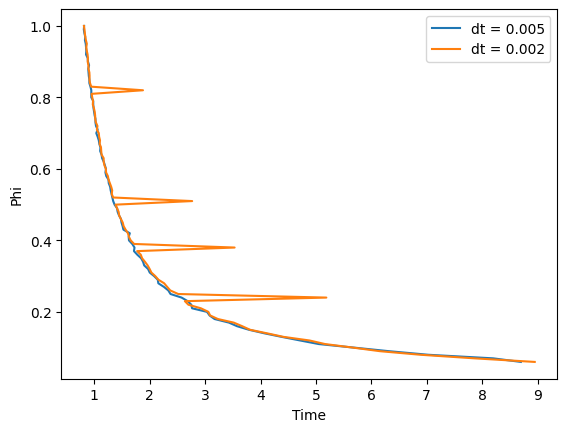

In [14]:
%matplotlib inline
plt.plot(np.array(times2)*0.005, phis2)
plt.plot(
    np.array(times)*0.002, phis
)
plt.xlabel('Time')
plt.ylabel('Phi')
plt.legend(
    [
        'dt = 0.005',
        'dt = 0.002'
    ]
)

2024-06-28 15:43:51 - DEBUG - Loaded backend inline version unknown.


Text(0, 0.5, 'Phi')

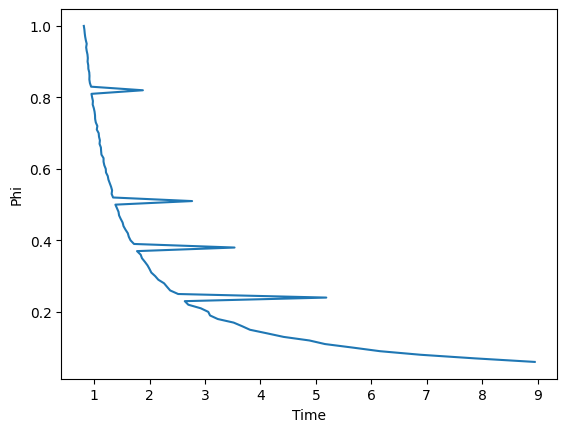

In [12]:
%matplotlib inline
plt.plot(0.002*np.array(times), phis)
plt.xlabel('Time')
plt.ylabel('Phi')

In [ ]:
from typing import Any
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

class MLRegressor:
    def __init__(self, regressor: BaseEstimator) -> None:
        """
        Initializes the MLRegressor with a given regressor.

        Args:
            regressor (BaseEstimator): A machine learning regressor that follows the scikit-learn regressor interface.
        """
        self.regressor: BaseEstimator = regressor
        self.is_fitted: bool = False

    def fit(self, X: np.ndarray, Y: np.ndarray, test_size: float = 0.2, random_state: int = None) -> None:
        """
        Splits the data into training and testing sets, then fits the regressor on the training set.

        Args:
            X (np.ndarray): The feature matrix.
            Y (np.ndarray): The target variable array.
            test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
            random_state (int, optional): Controls the shuffling applied to the data before applying the split. Defaults to None.
        """
        self.regressor.fit(X, Y)
        self.is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
        Makes predictions using the fitted regressor on the provided feature matrix.

        Args:
            X (np.ndarray): The feature matrix for which to make predictions.

        Returns:
            np.ndarray: The predicted values.

        Raises:
            RuntimeError: If the regressor has not been fitted yet.
        """
        if not self.is_fitted:
            raise RuntimeError("The regressor has not been fitted yet. Please call the fit method first.")
        return self.regressor.predict(X)